## Load all the scripts
Here, all the modules are called using the _import-ipynb_ librairy. To install, use command :
``` python
!pip install import-ipynb 
```

This imports all the functions to this notebook

In [58]:
#load all the functions from other scripts
import import_ipynb
import time
%run IP/IP_methods.ipynb #Image processing script
%run PathPlanning.ipynb
%run localisation.ipynb
%run local_navigation_final.ipynb
%run follow_road.py
%run path_following.ipynb

You should consider upgrading via the 'C:\Users\franc\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\franc\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


# __1) Vision__
Here are called all the function related to the vision of this project.
## Constants and parameters

In [2]:
#folder name where the generated files will be stored
Path_to_MAP = 'output'

#whether to plot the vision outputs or not
plot_vis = True

## Call to functions
Here, only one top level function is needed. The image and the needed to be put in correct places. The start position and angle are returned as variables for easy access throughout the code

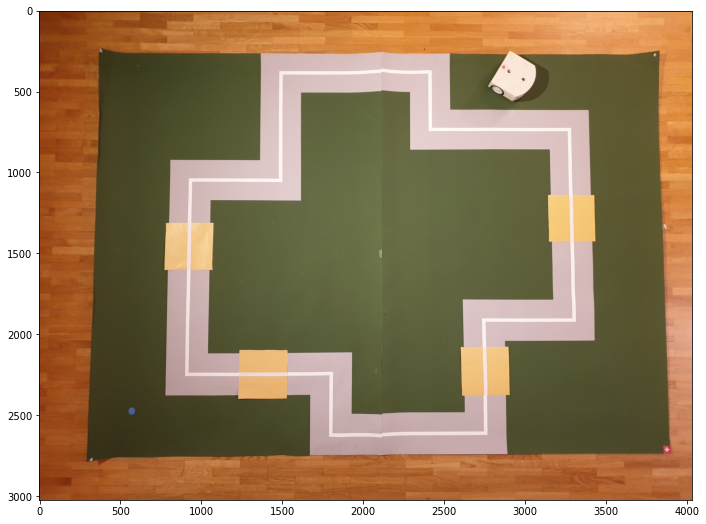

starting trimming img


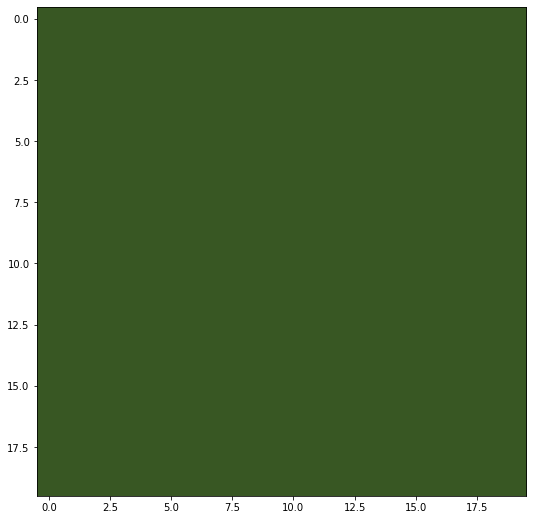

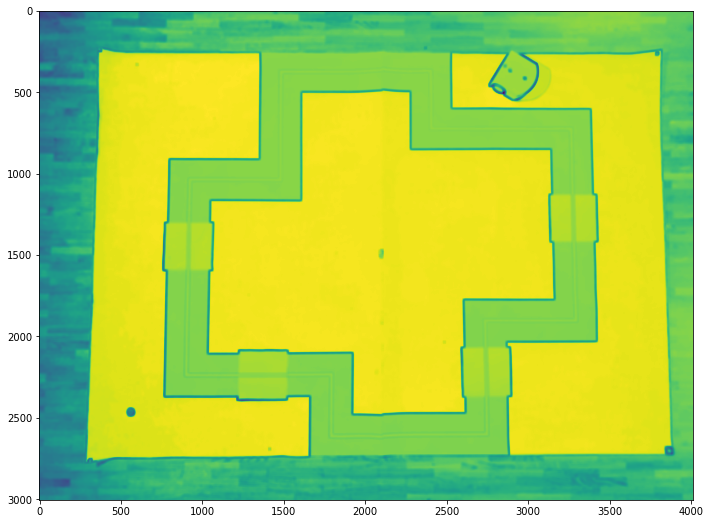

Trim finished


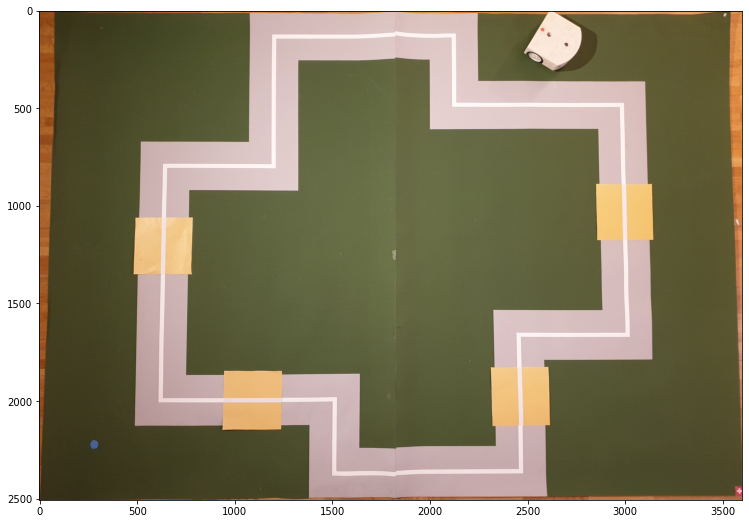

start finding thymio


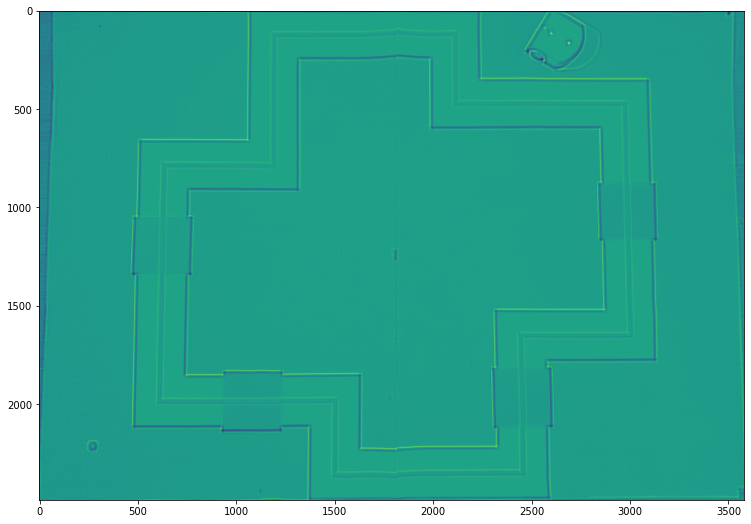

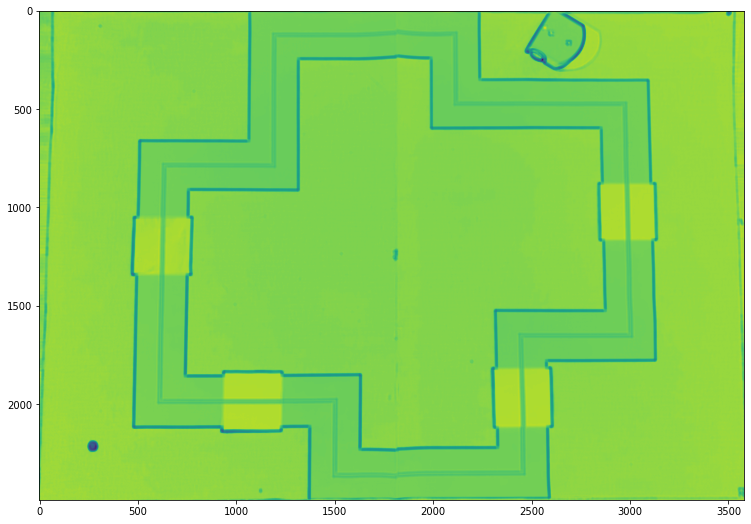

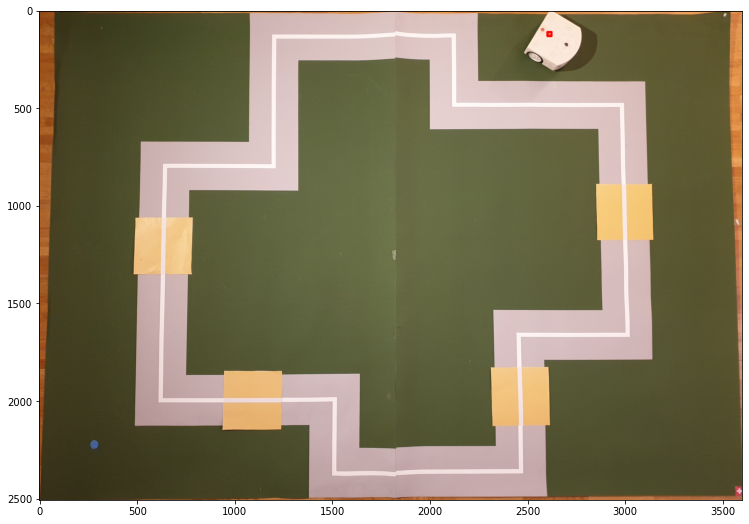

finished finding thymio
start detecting target position


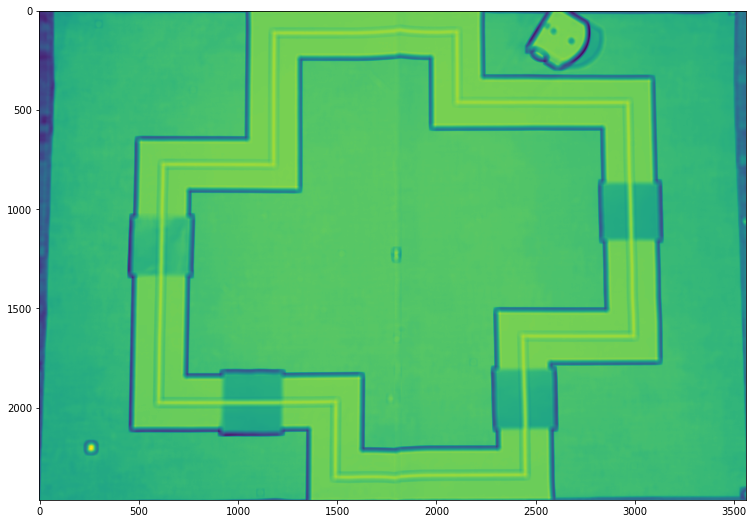

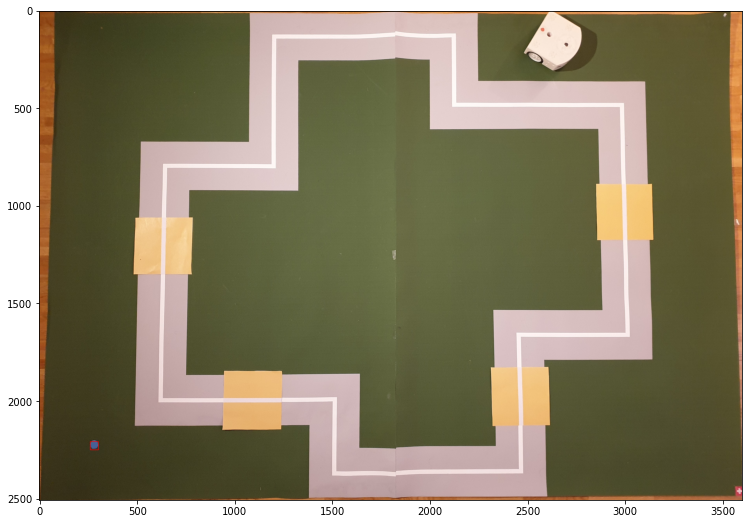

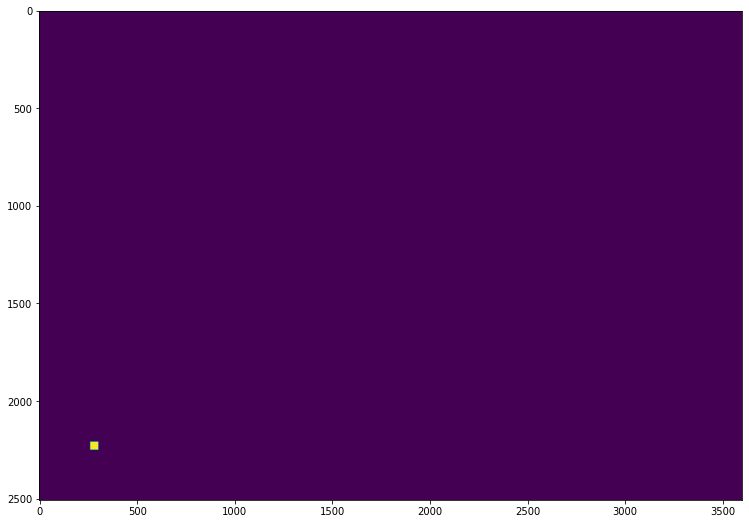

finish detecting target


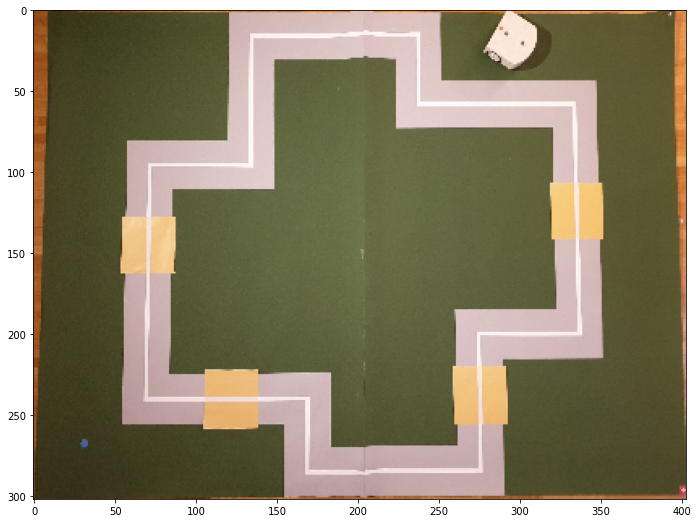

start detecting edge roads


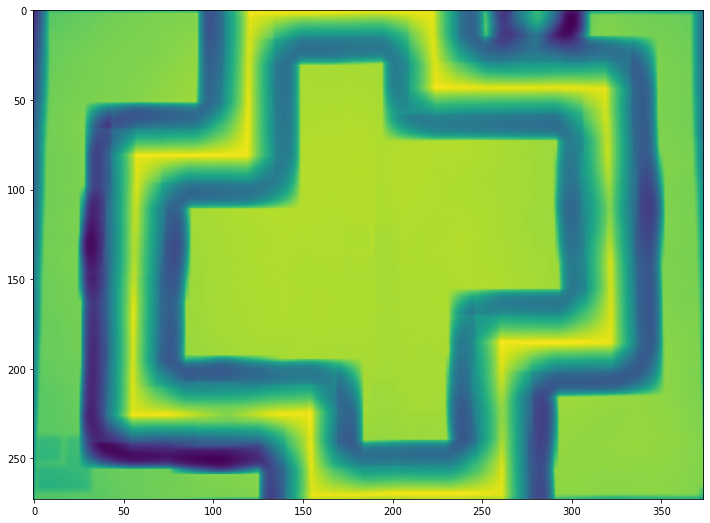

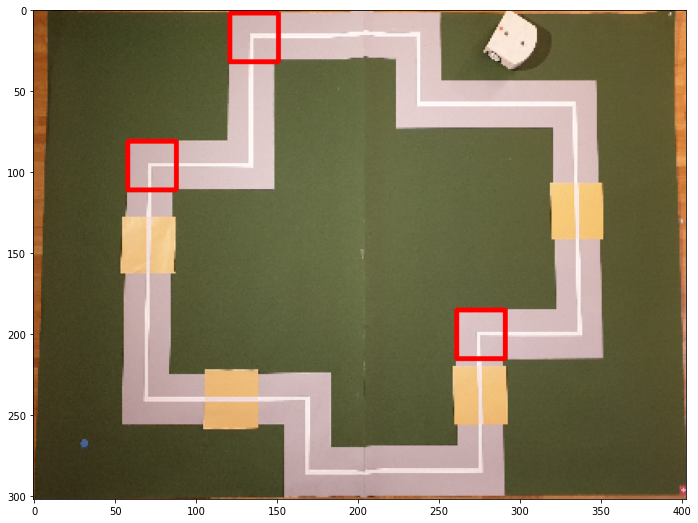

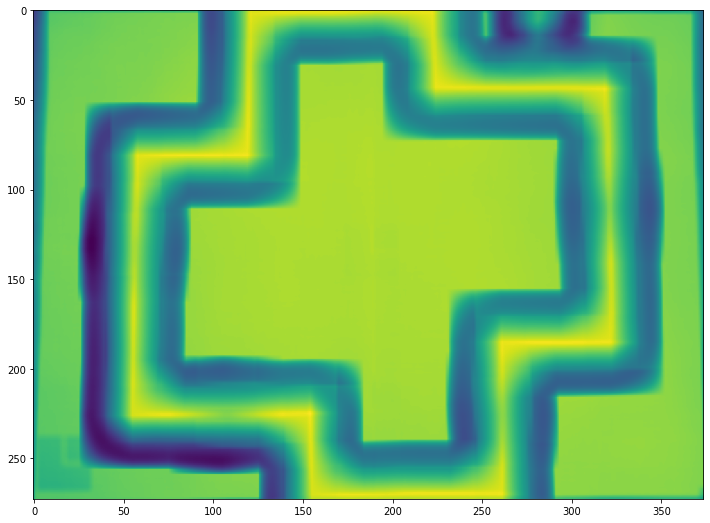

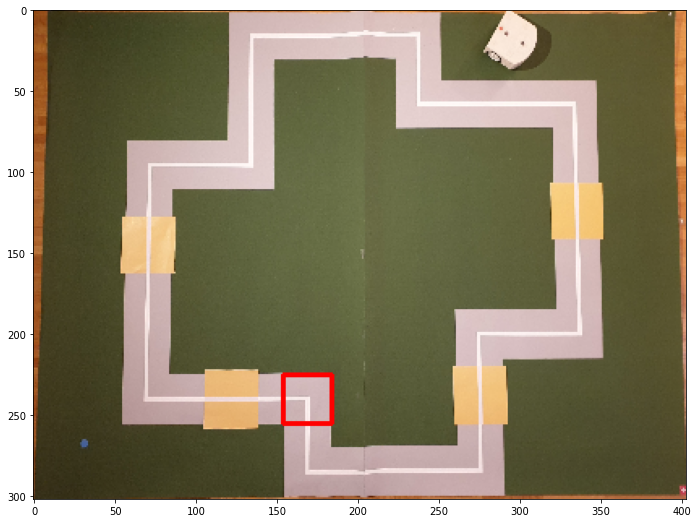

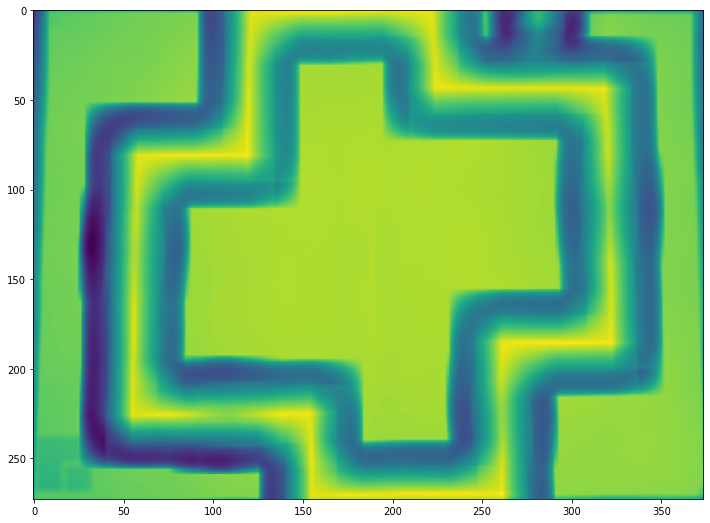

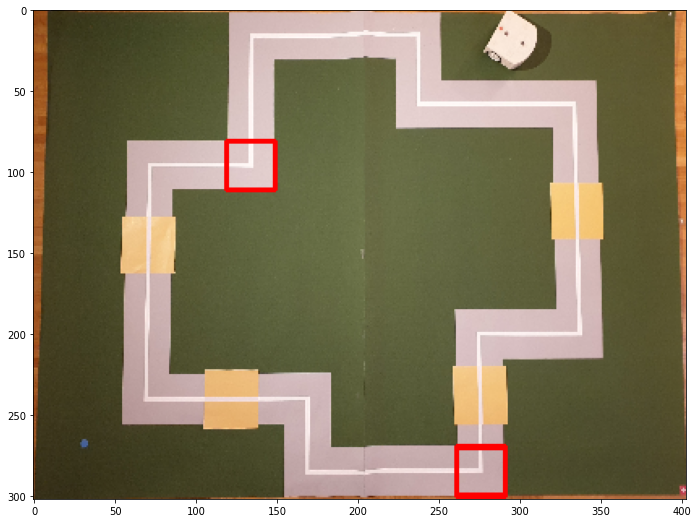

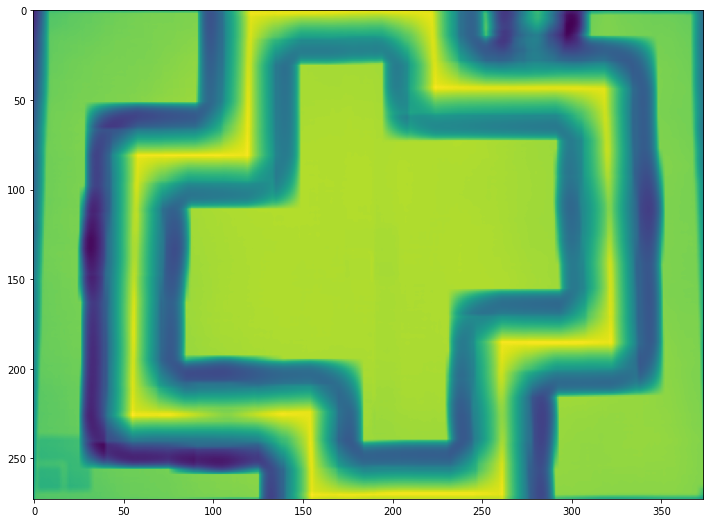

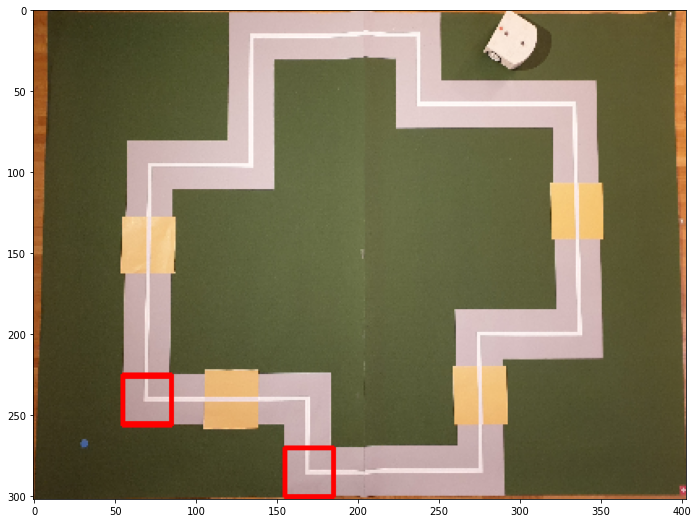

start detecting straigth roads


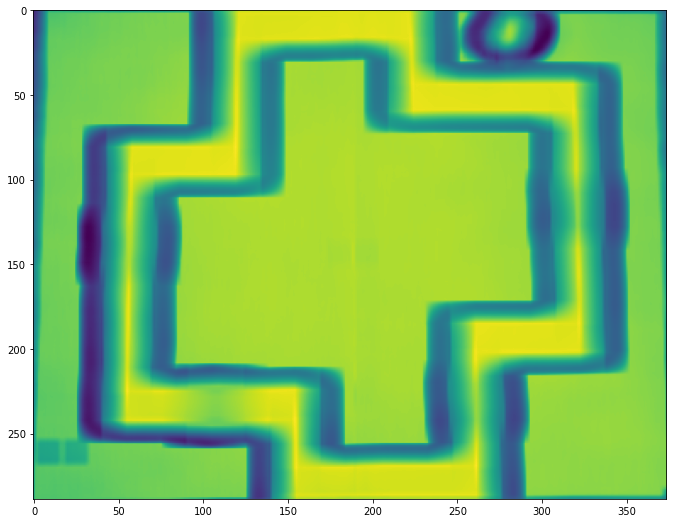

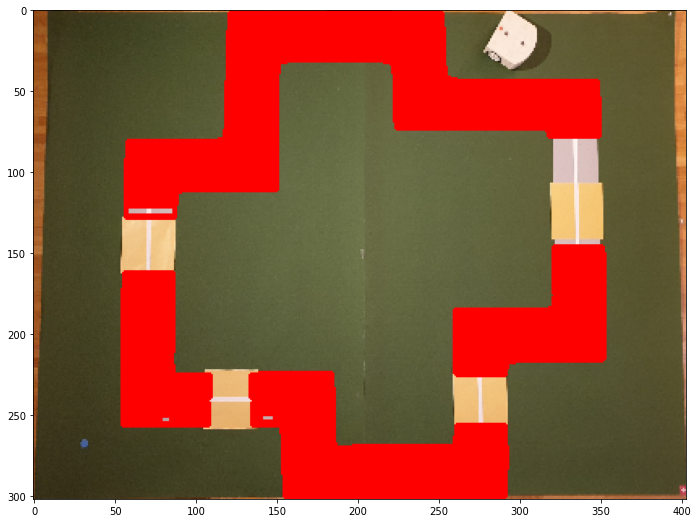

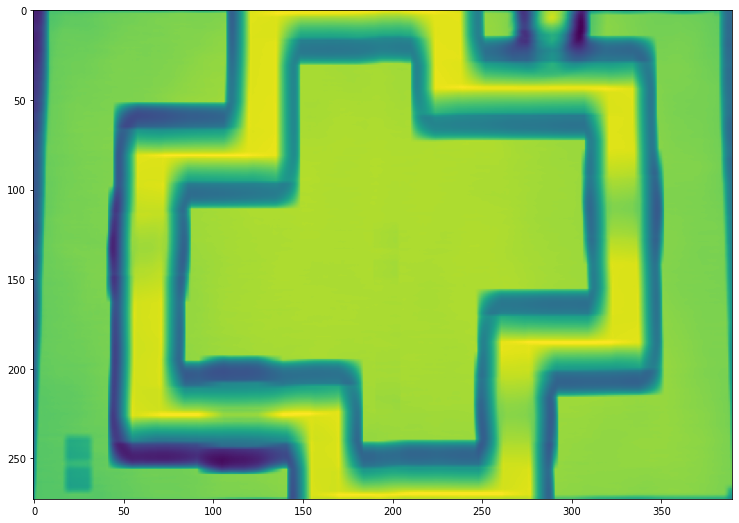

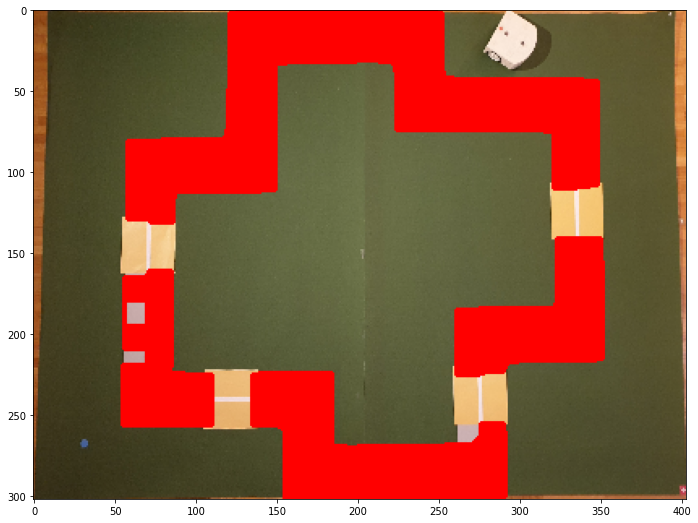

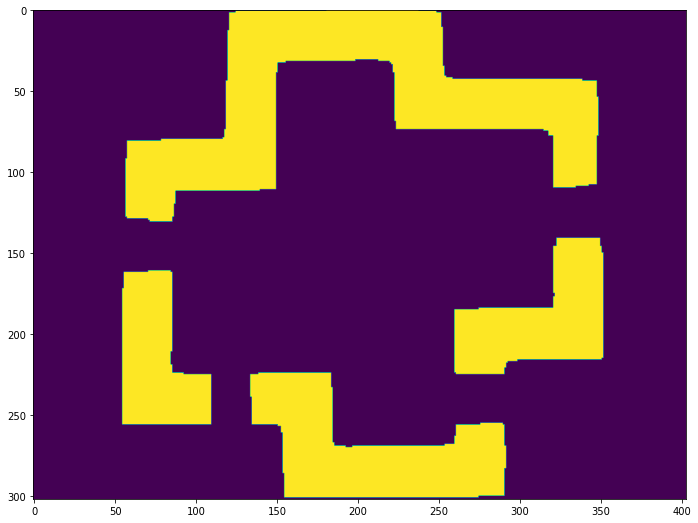

finish detecting roads
start detecting crossroads


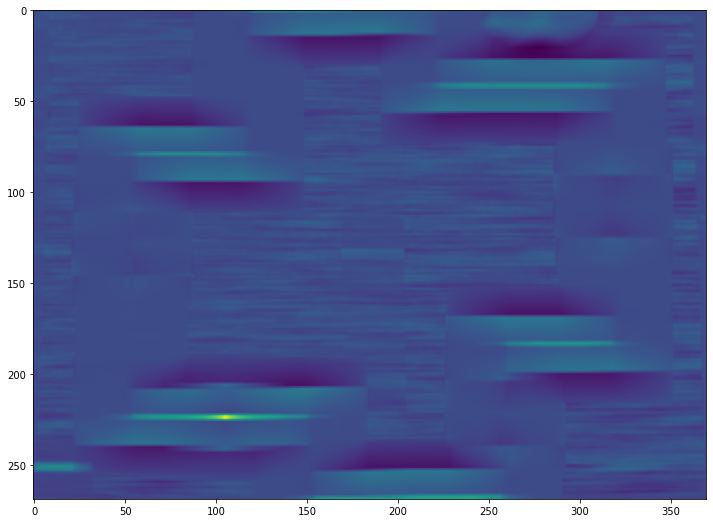

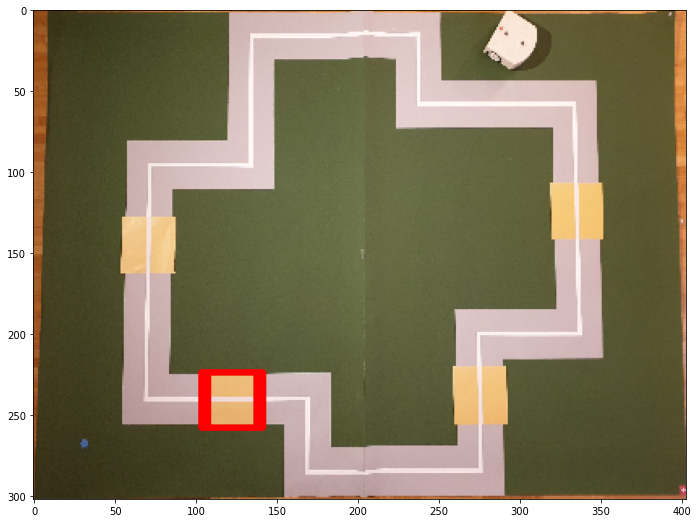

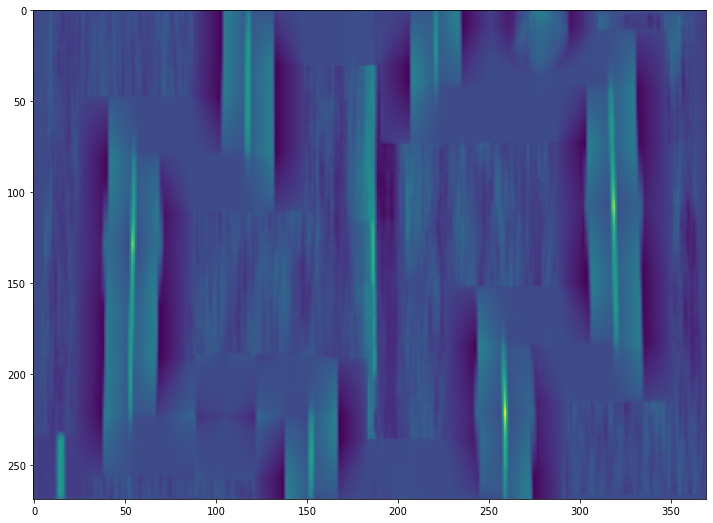

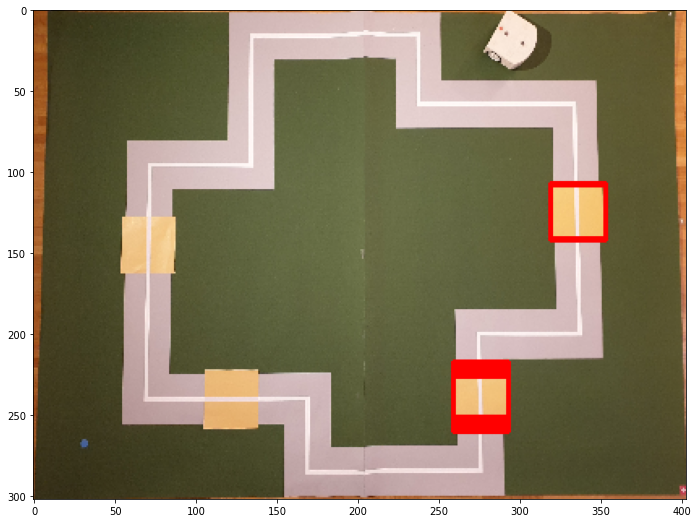

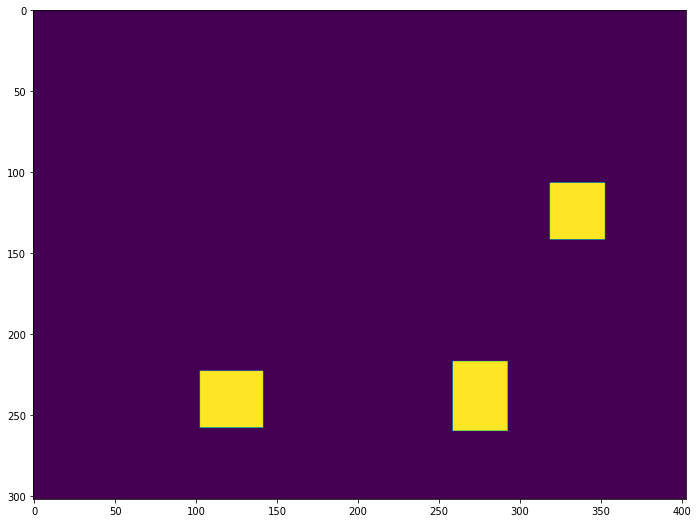

finish detecting cross roads


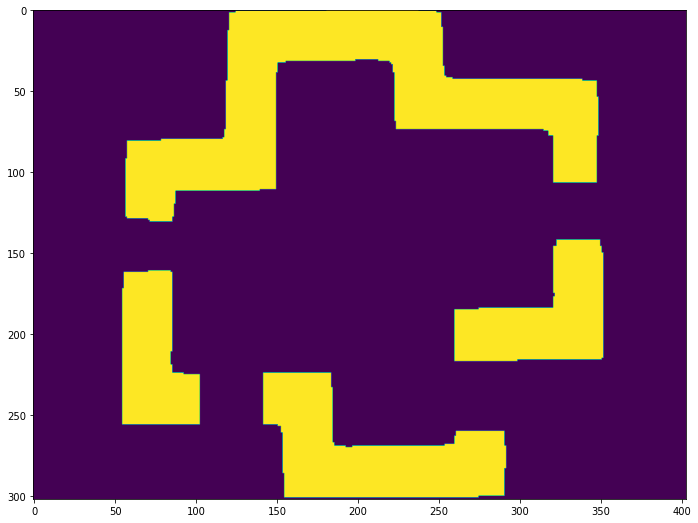

Image Processing finished in 45.309367418289185 seconds 


In [3]:
(x,y), orientation = pipeline_IP(plot_vis)
start = [x,y]

# __2) Path Planning__
## Constants and variables
The constants are named in all caps for easy identification. They should never change during the code.

In [4]:
#thymio radius 95 mm between the wheels
RADIUS = 40

#A0 size 841 x 1188 mm
XSIZE = 2*841
YSIZE = 1188
DESIRED_SIZE=[XSIZE, YSIZE]



# Variables
epsilon_path_plan =  2000 # If the thymio chooses to exit the map, increase
smoothing_factor= 0.01 # smoothing factor, smaller is more smooth
csvPath = Path_to_MAP + "/obst.csv"
savePath = Path_to_MAP + "/csvIM.png"

goalPath = Path_to_MAP + "/goal.csv"
goalsavePath = Path_to_MAP + "/csvIM_goal.png"

graph_name = Path_to_MAP + '/graph'

plot_pp = True
verbose_pp = False

## Call to functions
The offline part is only called at the start to build the vision graph. Here the online part is also called, but can be called again during the rest of the code with a new starting position.

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 62.58it/s]


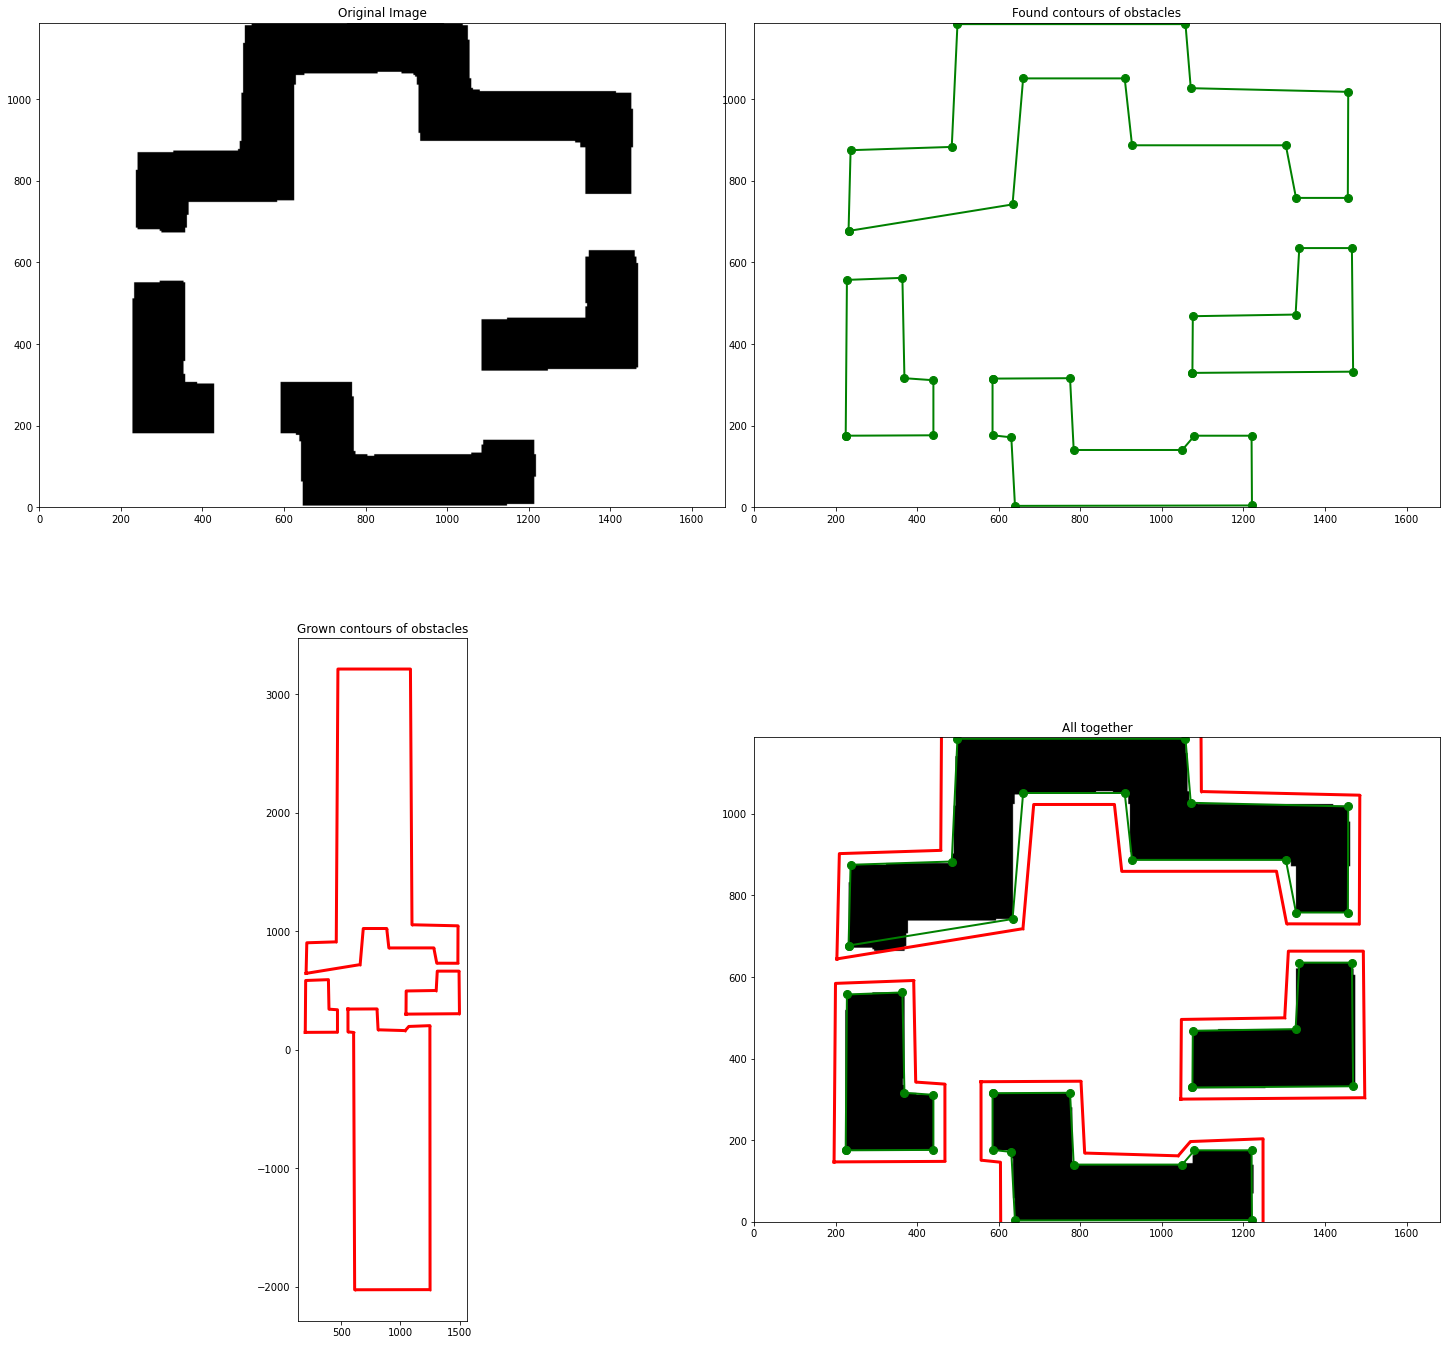

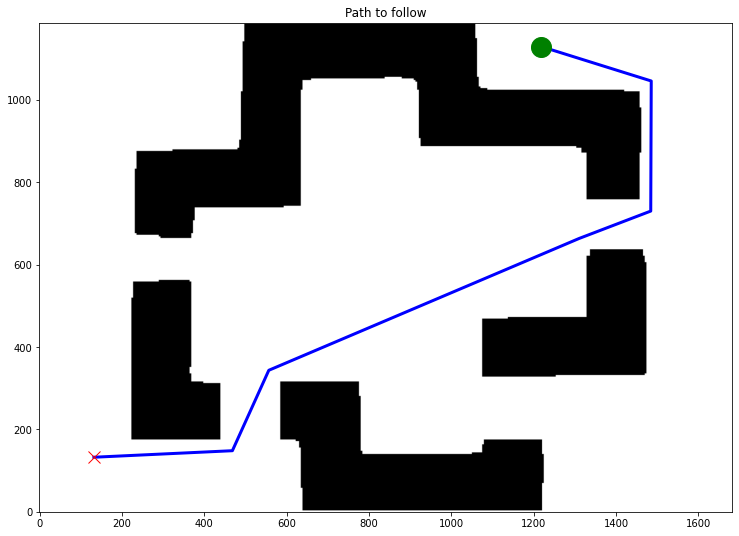

In [5]:

[xs, ys] = np.genfromtxt(csvPath, delimiter=',').shape
startx = (start[0])*XSIZE/(ys)
starty = start[1]*YSIZE/xs
start = [startx, starty]
goal = PathPlanning_offline(graph_name, csvPath, savePath, goalPath, goalsavePath, DESIRED_SIZE, 
                         smoothing_factor, RADIUS, epsilon_path_plan, plot_pp, verbose_pp)
path, inObstacle = PathPlanning_online(graph_name, start, goal, savePath, RADIUS, plot_pp, verbose_pp)

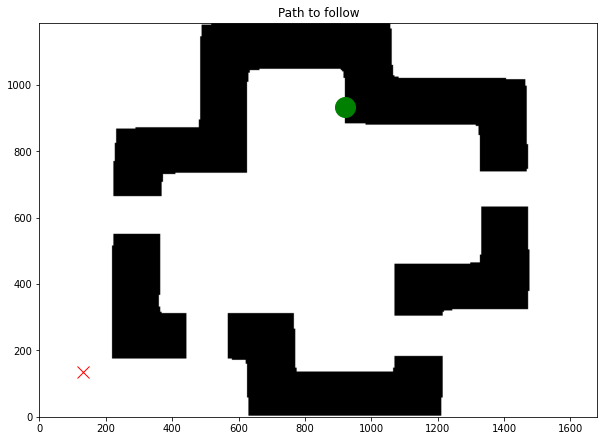

In [16]:
img = cv2.imread(savePath)
fig = plt.figure(figsize=(10,10))
plt.title("Path to follow")
plt.imshow(img, aspect = 'equal',origin = 'lower')
plt.plot(start[0], start[1], color = 'green', markersize=RADIUS/2 ,marker='o')
plt.plot(goal[0], goal[1], color = 'red', markersize=12 ,marker='x')

Thymio in an obstacle, no new path computed


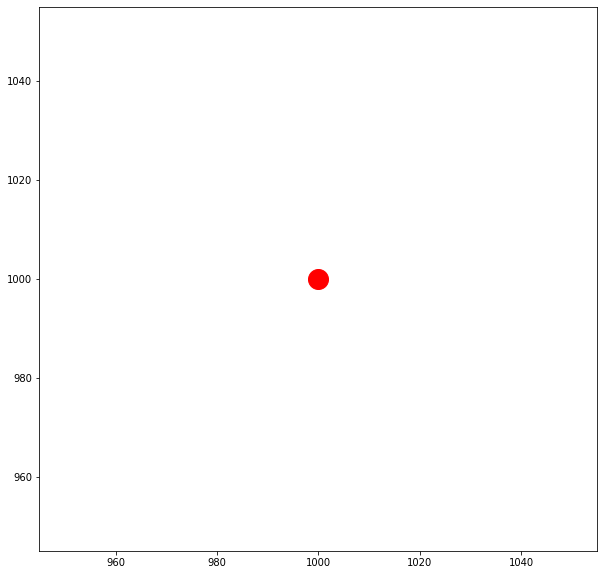

In [17]:
fig = plt.figure(figsize=(10,10))
_ ,_ = PathPlanning_online(graph_name, start, goal, savePath, RADIUS, True)
plt.plot(1000,1000, color = 'red', markersize=RADIUS/2 ,marker='o')
plt.show()

# Main loop of the algorithm 
In this loop is the state machine that runs the algorithm

In [51]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [52]:
def get_angle_goal_thymio(tm_pos,tm_orient, goal_pos):
    """
    This function computes the angle between the direction the Thymio should point and the orientation of the robot 
    in order to be aligned with the goal
    
    Arguments: th_pos:    position of the Thymio 
               th_orient: orientation of the robot
               goal_pos:  [X,y] coordinates of the goal
               
    Return   : computed angle in range [-pi;pi]
    """
    
    #we start by computing the direction of the vector connecting the pose of the robot and the goal
    alpha = math.atan2(goal_pos[1]-tm_pos[1], goal_pos[0]-tm_pos[0])
    if alpha < 0:
        alpha += 2*math.pi
    
    theta = tm_orient-alpha
    
    if theta > math.pi:
        theta -= 2*math.pi
    if theta < -math.pi:
        theta += 2*math.pi

    return theta

In [53]:
angle_I_error = 0
def angle_PI(tm_pos, tm_orient, goal_pos, reset):
    """
        This function calulates the PI term related to the orientation of the robot to orient the robot to face the goal
    
    Arguments: Arguments: th_pos:    position of the Thymio 
               th_orient: orientation of the robot
               goal_pos:  [X,y] coordinates of the goal
               reset   : bool True if we want to reset the Integral error sum
    
    Return   : Speed increment to add/substract to the motors
    """
    #precision factor by which we first multiply the errors to gain in precision as the speed has to be an integer 
    #and truncation may affect the results
    PRECISION_FACTOR = 100
    max_error_sum = 1
    min_dist_to_goal = 10 #if we are next to the goal of 1 cm we do not update as we consider we are on the goal
    
    #we want to saturate the speed so we have a trapezoidal speed profile for smoothness of movement
    max_speed = 80
    Kp = 80
    Ki = 5
    
    global angle_I_error
    
    if reset:
        angle_I_error = 0
    
    #checking if we are on the gaol pos
    dist = math.sqrt((tm_pos[0]-goal_pos[0])**2+(tm_pos[1]-goal_pos[1])**2)
    
    if dist < min_dist_to_goal:
        return 0
    
    error = get_angle_goal_thymio(tm_pos, tm_orient, goal_pos)
    #print("error")
    #print(error)
    angle_I_error += error
    
     #antireset windup
    if angle_I_error > max_error_sum:
        angle_I_error = max_error_sum
        
    if angle_I_error < -max_error_sum:
        angle_I_error = -max_error_sum
    
    #print("int error")
    #print(angle_I_error)
    
    speed_angle = int(((Kp*error+Ki*angle_I_error)))
    #print("speed_angle")
    #print(speed_angle)
    
    if speed_angle > max_speed:
        speed_angle = max_speed
    if speed_angle < -max_speed:
        speed_amgle = -max_speed
    
    return speed_angle

In [54]:
dist_error_sum = 0
def distance_PI(tm_pos, tm_orient, goal_pos, reset):
    """
      This function returns the speed associated to the displacement of the robot so that it reaches the goal position
        
    
    Arguments: Arguments: th_pos:    position of the Thymio 
               th_orient: orientation of the robot
               goal_pos:  [X,y] coordinates of the goal
               reset   : bool True if we want to reset the Integral error sum
    
    Return   : Speed increment add to both motors
    """
    Max_dist_error = 20
    SCALING_FACTOR = 10
    max_speed = 150 #doesn't allow a speed larger than this value so that the dynamic is homogenous (speed doesn't linearly
                    #decrease until we are close to the goal)
    
    min_dist_to_goal = 0 #if we are next to the goal of 1 cm we do not update as we consider we are on the goal
    
    global dist_error_sum
    
    if reset:
        dist_error_sum = 0
        
    dispacement_speed = 0
    Kp = 20
    Ki = 4
    
    #compute the distance
    
    dist = math.sqrt((tm_pos[0]-goal_pos[0])**2+(tm_pos[1]-goal_pos[1])**2)
    if dist <  min_dist_to_goal:
        dist = 0
    
    #if the Thymio orientation is too far from facing the goal, we first reorient the robot until it faces the goal => 
    #no displacement speed
    Phi = get_angle_goal_thymio(tm_pos,tm_orient, goal_pos)
    if Phi> math.pi/2 or Phi <-math.pi/2:
        displacement_speed = 0
    else:
        dist_error_sum += dist
        
        #antireset windup
        if dist_error_sum > Max_dist_error:
            dist_error_sum = Max_dist_error
        if dist_error_sum < -Max_dist_error:
            dist_error_sum = -Max_dist_error
        
        displacement_speed = int((dist*Kp+Ki*dist_error_sum)//SCALING_FACTOR)
        
        #saturates the speed if needed
        if displacement_speed > max_speed:
            displacement_speed = max_speed
        if displacement_speed < -max_speed:
            displacement_speed = -max_speed
    
    return displacement_speed
    

pose
Current position:
x = 		500
y = 		500
theta = 	0

coords of robot
Current position:
x = 		500
y = 		500
theta = 	0

speeds
[176, 255]
	Default values are used instead.
coords of robot
Current position:
x = 		499.62
y = 		500.0
theta = 	0.01

speeds
[177, 254]
	Default values are used instead.
coords of robot
Current position:
x = 		510.84
y = 		500.53
theta = 	0.09

speeds
[186, 242]
	Default values are used instead.
coords of robot
Current position:
x = 		522.42
y = 		501.87
theta = 	0.14

speeds
[192, 233]
	Default values are used instead.
coords of robot
Current position:
x = 		534.92
y = 		503.98
theta = 	0.19

speeds
[197, 226]
	Default values are used instead.
coords of robot
Current position:
x = 		546.83
y = 		506.4
theta = 	0.21

speeds
[198, 221]
	Default values are used instead.
coords of robot
Current position:
x = 		558.99
y = 		509.18
theta = 	0.24

speeds
[200, 216]
	Default values are used instead.
coords of robot
Current position:
x = 		572.84
y = 		512.69
theta =

	Default values are used instead.
coords of robot
Current position:
x = 		913.75
y = 		406.15
theta = 	6.27

speeds
[57, 294]
	Default values are used instead.
coords of robot
Current position:
x = 		923.16
y = 		406.82
theta = 	0.16

speeds
[79, 271]
	Default values are used instead.
coords of robot
Current position:
x = 		931.54
y = 		408.77
theta = 	0.3

speeds
[96, 252]
	Default values are used instead.
coords of robot
Current position:
x = 		941.11
y = 		412.36
theta = 	0.42

speeds
[110, 235]
compmute left side cost
tm pos
(941.1064767190588, 412.3607848033929)
goal_pos
[1200, 700]
y_larger
goal_cost
0
prox_cost
281.8
compute right side cost
tm pos
(941.1064767190588, 412.3607848033929)
goal_pos
[1200, 700]
y_larger
goal_cost
143.81960759830355
prox_cost
0
	Default values are used instead.
	Default values are used instead.
	Default values are used instead.
	Default values are used instead.
	Default values are used instead.
	Default values are used instead.
free path iter
1
	Defau

NameError: name 'graph_name' is not defined

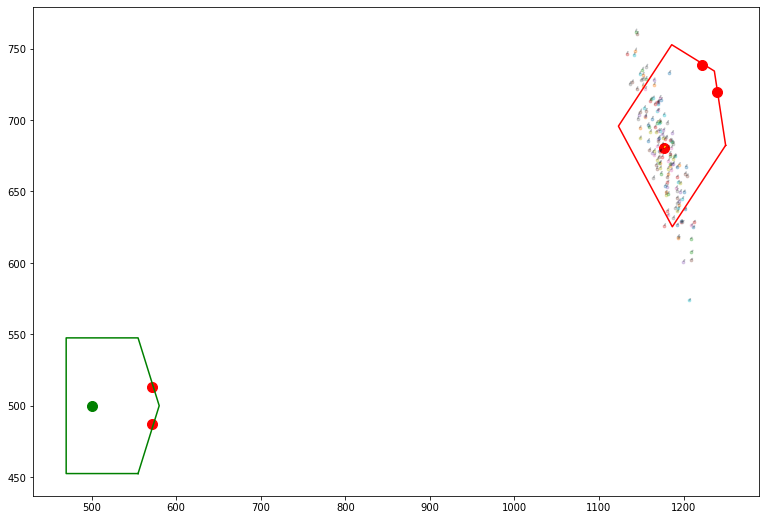

<Figure size 720x720 with 0 Axes>

In [60]:
#putting everything together
#putting together functions
obstacle = False
motor_left_target = 0
motor_right_target = 0
ITER_PATH_FREE = 14 #number of iteration where the path to the goal is free before we stop following the obstacle
dist_thresh = 20
#States of the robot
STATE_GLOBAL_NAV = 0
STATE_LOCAL_NAV = 1

#Threshold for obstacle detection
THRESHOLD_PROX1 = 1700
THRESHOLD_PROX2 = 1500
THRESHOLD_PROX3 = 1500
THRESHOLD_PROX0 = 1800
THRESHOLD_PROX4 = 1800

#refresh period
dt = 0.08

#initliasie the pose of the robot
start_pos = [500,500]#path[0]
pose = Pose(start_pos[0],start_pos[1],0,nb_particles = 150)# orientation
#pose.set_coords(500, 500, math.pi/2)
print("pose")
print(pose)

robot_state = STATE_GLOBAL_NAV

#objective
goals = [[1200,700]]#path[1:]
coords = pose.get_coords()


#initialize variable for the loop
go_left = True
reset_glob_regulator = True
reset_local_regulator = True
speeds_robot = [0, 0]
obstacle = False
#plot_counter = 0

#counters used to determine if we must reset the PID controllers (integrator terms and derivatives)
local_nav_iter = 1
global_nav_iter = 1
#for local navigation counts how many consecutive iteration the path is free (used to go back to global nav)
free_path_iter = 0 
pose.plot(plot_theta = False)
goal_idx = 0
goal = goals[goal_idx]

dist_to_goal = math.sqrt((coords['x']-goal[0])**2+(coords['y']-goal[1])**2)
while dist_to_goal > dist_thresh and goal_idx <= len(goals)-1:
    t1 = time.time()
    #print("path")
    #print(path)
    
    if dist_to_goal<dist_thresh*2:
        goal_idx+=1
        #print("idx")
        #print(goal_idx)
        if goal_idx <= len(goals)-1:
            goal = goals[goal_idx]
        
    
    if robot_state == STATE_GLOBAL_NAV:
        
        
        if global_nav_iter > 1:
            reset_glob_regulator = False
        else:
            #print("GLOBAL")
            leds_circle[3] = 25
            leds_circle[1] = 0
            leds_circle[2] = 0

        global_nav_iter += 1
        
        prox = prox_horizontal
    
        obstacle = obstacle or obstacle_detected(prox[2], THRESHOLD_PROX2)
        obstacle = obstacle or obstacle_detected(prox[1], THRESHOLD_PROX1)
        obstacle = obstacle or obstacle_detected(prox[3], THRESHOLD_PROX3)
        obstacle = obstacle or obstacle_detected(prox[0], THRESHOLD_PROX0)
        obstacle = obstacle or obstacle_detected(prox[4], THRESHOLD_PROX4)
        if obstacle:
            leds_circle[2] = 25
        
        coords = pose.get_coords()
        print("coords of robot")
        print(pose)
        #speed_theta = angle_PI([coords['x'],coords['y']], coords['theta'], goal, reset_glob_regulator)
        #speed_disp = distance_PI([coords['x'],coords['y']], coords['theta'], goal, reset_glob_regulator)
        #speeds_robot = [speed_theta+speed_disp,speed_disp-speed_theta]
        speeds_robot = follow_path([coords['x'],coords['y'],coords['theta']],goal,reset_glob_regulator,dt) #[speed_theta+speed_disp,speed_disp-speed_theta]
        #follow_path([coords['x'],coords['y'],coords['theta']],goal,reset_glob_regulator,dt) #[speed_disp+speed_theta, speed_disp-speed_theta]
        print("speeds")
        print(speeds_robot)
        if obstacle:
            robot_state = STATE_LOCAL_NAV
            coords = pose.get_coords()
            Go_left = choose_direction(prox, goal, (coords['x'],coords['y']), coords['theta'])
            #print("Go_left")
            #print(Go_left)
            #print("IN OBSTCLE")
            reset_local_regulator = True
            local_nav_iter = 1
            free_path_iter = 0
            
            
    elif robot_state == STATE_LOCAL_NAV:
        
        prox = prox_horizontal
        
        if local_nav_iter > 1:
            reset_local_regulator = False
        else:
            #print("LOCAL")
            leds_circle[3] = 0
            leds_circle[1] = 25

            
        local_nav_iter += 1
        
        if Go_left:
        #if turn left obstacle is on the rigth
            speeds = right_obst_follow(reset_local_regulator)
            speeds_robot = [speeds[1], speeds[0]]
        
        
        else:
            speeds = left_obst_follow(reset_local_regulator)
            speeds_robot = [speeds[1], speeds[0]]
    
  
        coords = pose.get_coords()
    
        if path_to_goal_free(coords['theta'], (coords['x'],coords['y']), goal ,prox):
            free_path_iter += 1
            print("free path iter")
            print(free_path_iter)
            if free_path_iter > ITER_PATH_FREE:
                    robot_state = STATE_GLOBAL_NAV
                    print("PATH IS FREE")
                    global_nav_iter = 1
                    reset_glob_regulator = True
                    obstacle = False
                    
                    
        else:
            free_path_iter = 0
        
    
    motor_left_target = speeds_robot[0]
    motor_right_target = speeds_robot[1]
    
  
    sleep(dt)
    
    speeds_meas = [motor_left_speed,motor_right_speed]    
    prox_grnd = prox_ground_delta
    t2 = time.time()
    pose.update(speed=speeds_meas, prox=prox_grnd, dt=(t2-t1), myMap = myMap)
    
    coords = pose.get_coords()
    dist_to_goal = math.sqrt((coords['x']-goal[0])**2+(coords['y']-goal[1])**2)
    #if dist_to_goal < dist_thresh and goal_idx >= len(goals):
       #/ break
    
    
    #if plot_counter == 8:
     #   plot_counter = 0
      #  pose.plot(plot_theta = False)
    #plot_counter += 1

sleep(dt)
motor_left_target = 0
motor_right_target = 0
pose.plot()

fig = plt.figure(figsize=(10,10))
_ ,_ = PathPlanning_online(graph_name, [x,y], goal, savePath, RADIUS, True)
plt.show()

In [50]:
motor_left_target = 0
motor_right_target = 0

In [ ]:
await tdmclient.notebook.stop()

{'x': 1177.0949872031308, 'y': 680.6474090424779, 'theta': 0.73542158464506}

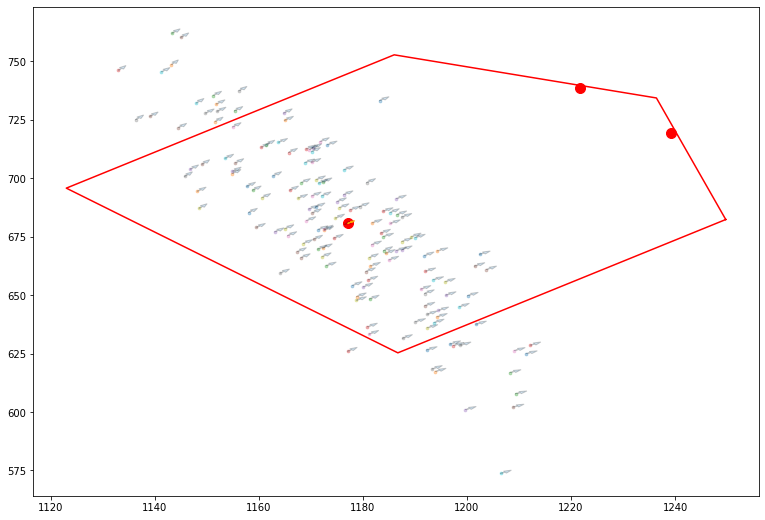

In [61]:
pose.plot()
pose.get_coords()

In [47]:
path

[]

In [48]:
start

[601.5099337748344, 50.11414392059553]

In [49]:

(x,y)

(52, 279)

In [8]:
orientation

5.800963982951733

In [23]:
math.atan2(0,600)

0.0

In [7]:
prox_ground_delta

[547, 321]